In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import random
import pickle
from multiprocessing import Pool
import gc

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

from keras import models, layers, losses, optimizers, Model
from keras.utils import plot_model

2023-11-07 23:19:34.774992: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 23:19:34.775020: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 23:19:34.775909: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gc.collect()

0

In [3]:
def get_feature_vectors():
    with open("feature_vecs.txt", "r") as f:
        f = f.read().split("\n\n\n")
        noun_dict = {}
        for noun_vec in f:
            split = noun_vec.split("\n\n")
            noun = split[0].split()[2][:-1]
            
            vec = split[1]
            vec = [item.strip().replace("(", "").replace(")", "") for item in vec.split(",\n")]
            vec = [(item.split()[:-1], item.split()[-1]) for item in vec]

            vec = sorted(vec, key=lambda x: x[0])
            vec = {" ".join(item[0]): float(item[1]) for item in vec}

            noun_dict[noun] = vec

    return {k: [noun_dict[k][k1] for k1 in noun_dict[k]] for k in noun_dict}


In [4]:
NUM_CLASSES = 60

pickles = [pickle.load(open(f"pickles/{i}.pkl", "rb")) for i in range(1)]
pickles = [item for sublist in pickles for item in sublist]
pickles = sorted(pickles, key=lambda x: x[1])

nouns = list(set([item[1] for item in pickles]))
random.shuffle(nouns)
nouns_train = nouns[:-2]
nouns_test = nouns[-2:]

feature_vectors = get_feature_vectors()
train_x = np.expand_dims(np.array([feature_vectors[item[1]] for item in pickles if item[1] in nouns_train]), -1)
train_y = np.expand_dims(np.array([item[0] for item in pickles if item[1] in nouns_train]), -1)

test_x = np.expand_dims(np.array([feature_vectors[item[1]] for item in pickles if item[1] in nouns_test]), -1)
test_y = np.expand_dims(np.array([item[0] for item in pickles if item[1] in nouns_test]), -1)

print(len(train_x), len(train_y))
del pickles

347 347


In [5]:
def plot_scan(scan):
    scan[scan == mode(scan.flat).mode] = -1
    w = 5
    fig, ax = plt.subplots(w, w, constrained_layout=True)
    fig.dpi = 100
    bg_color = (225 / 255, 216 / 255, 226 / 255)
    fig.set_facecolor(bg_color)

    for j in range(w * w):
        ax[(j - j % w) // w, j % w].imshow(scan[j % scan.shape[0]], vmin=-1, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w].set_xticks([])
        ax[(j - j % w) // w, j % w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

        plt.show()

In [6]:
def double_plot(scan1, scan2):
    scan1[scan1 == mode(scan1.flat).mode] = scan1.min()
    scan2[scan2 == mode(scan2.flat).mode] = scan2.min()

    scan1 = (scan1 - scan1.min()) / (scan1.max() - scan1.min())
    scan2 = (scan2 - scan2.min()) / (scan2.max() - scan2.min())
    scan1 = (scan1 - 0.5) * 2
    scan2 = (scan2 - 0.5) * 2

    w = 5
    fig, ax = plt.subplots(w, 2 * w, constrained_layout=True)
    fig.dpi = 100
    bg_color = (225 / 255, 216 / 255, 226 / 255)
    fig.set_facecolor(bg_color)

    for j in range(w * w):
        ax[(j - j % w) // w, j % w].imshow(scan1[j % scan1.shape[0]], vmin=-1, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w].set_xticks([])
        ax[(j - j % w) // w, j % w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

        ax[(j - j % w) // w, j % w + w].imshow(scan2[j % scan2.shape[0]], vmin=-1, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w + w].set_xticks([])
        ax[(j - j % w) // w, j % w + w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w + w].spines.values(), color=bg_color)

In [7]:
class BasisSum(Model):
    def __init__(self):
        super().__init__()
        self.basis = tf.Variable(tf.zeros((25, 23, 61, 51, 1)))

    @tf.function(reduce_retracing=True)
    def call(self, x):
        x = tf.einsum("ijklm,bim->bjklm", self.basis, x)

        return x

0.7275276780128479 0 0.7274625301361084
1 0.4108758866786957
2 0.41003191471099854
3 0.40872734785079956
4 0.40706291794776917
5 0.4051016569137573
6 0.40288999676704407
7 0.4004654884338379
8 0.3978588283061981
9 0.395094633102417
10 0.39219632744789124
11 0.3891812264919281
12 0.38606634736061096
13 0.38286590576171875
14 0.3795921802520752
15 0.37625616788864136
16 0.3728674352169037
17 0.3694342374801636
18 0.36596447229385376
19 0.36246445775032043
20 0.3589398264884949
21 0.3553955554962158
22 0.3518357276916504
23 0.3482644855976105
24 0.3446844816207886
25 0.34109869599342346
26 0.3375093936920166
27 0.3339183032512665
28 0.3303270637989044
29 0.32673758268356323
30 0.3231511414051056
31 0.31956785917282104
32 0.31598961353302
33 0.3124164640903473
34 0.3088494539260864
35 0.3052898049354553
36 0.3017371892929077
37 0.2981935441493988
38 0.29465875029563904
39 0.29113367199897766
40 0.287619411945343
41 0.284116268157959
42 0.28062528371810913
43 0.277147114276886
44 0.27368256

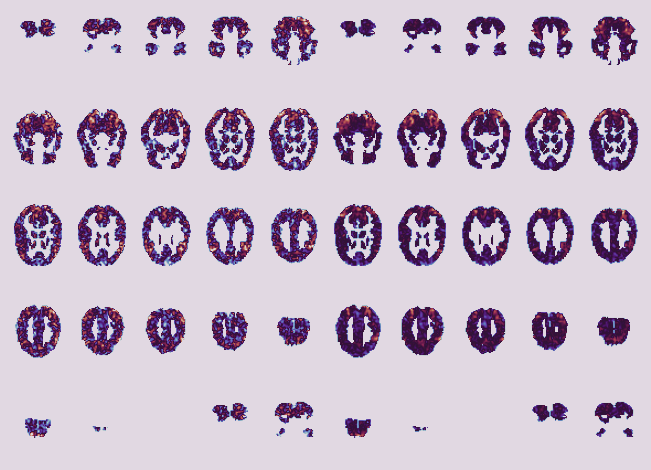

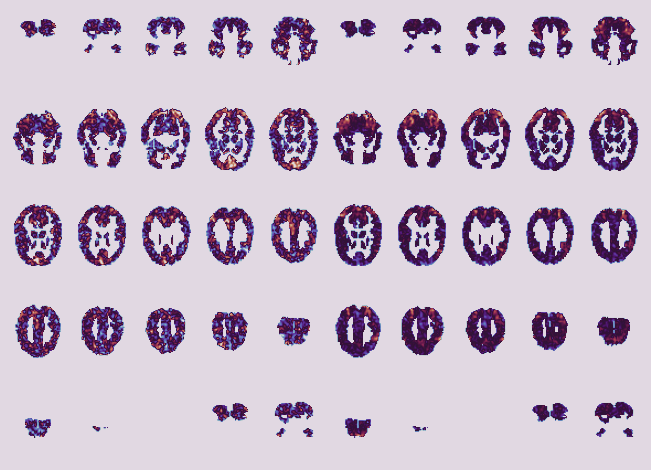

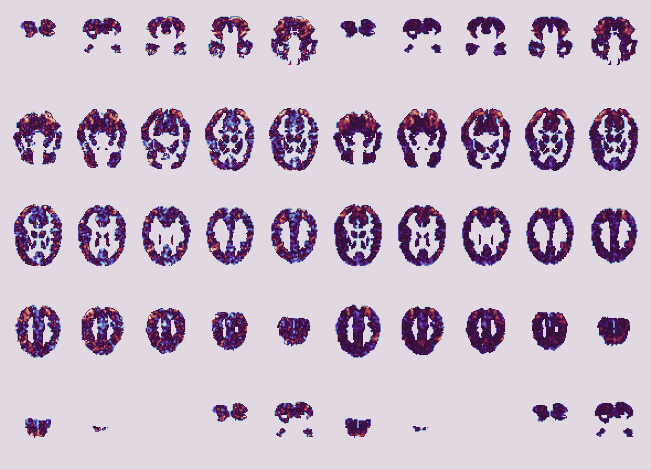

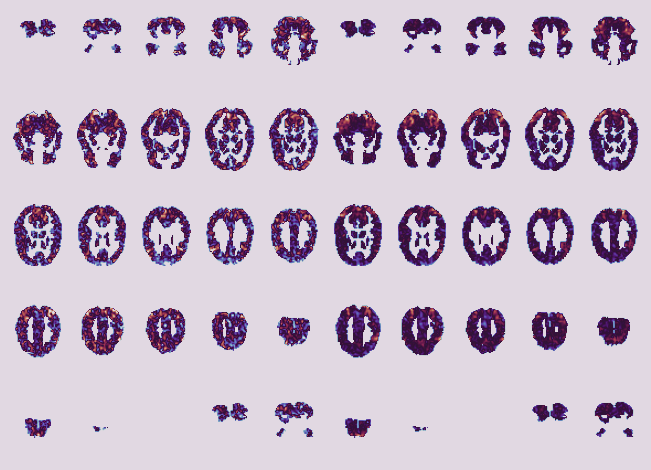

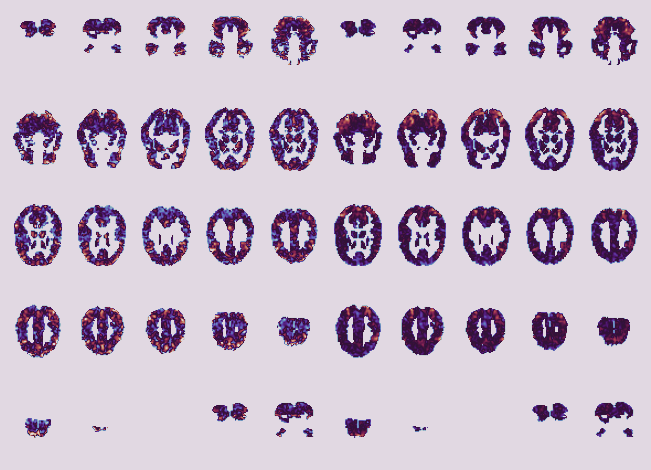

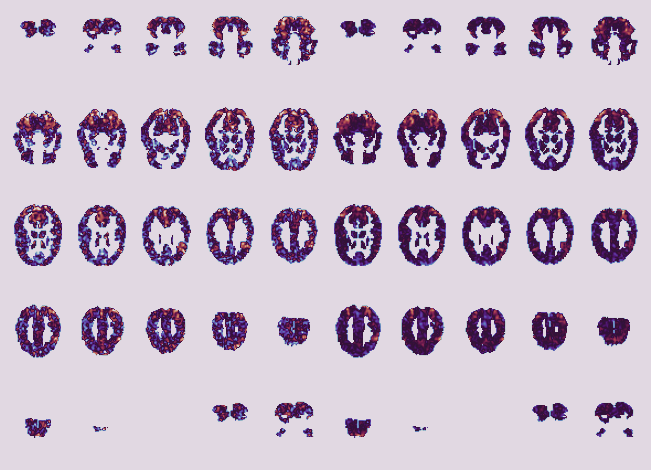

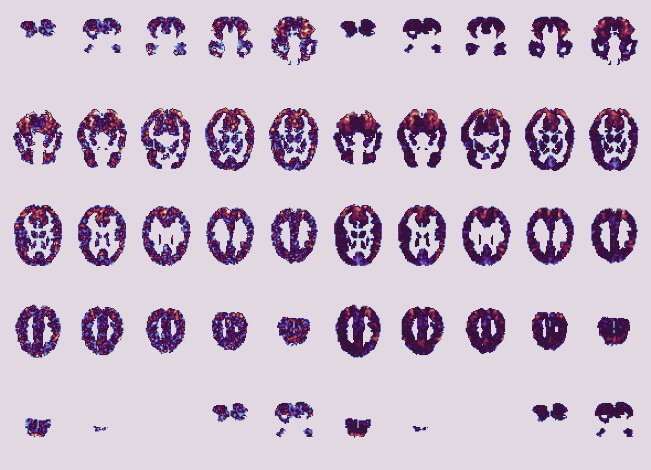

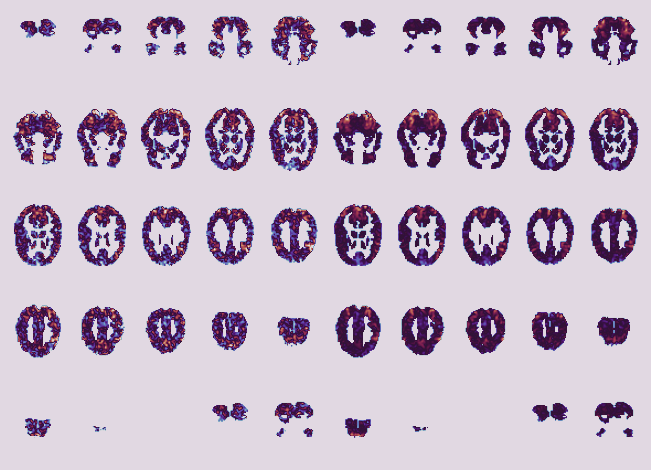

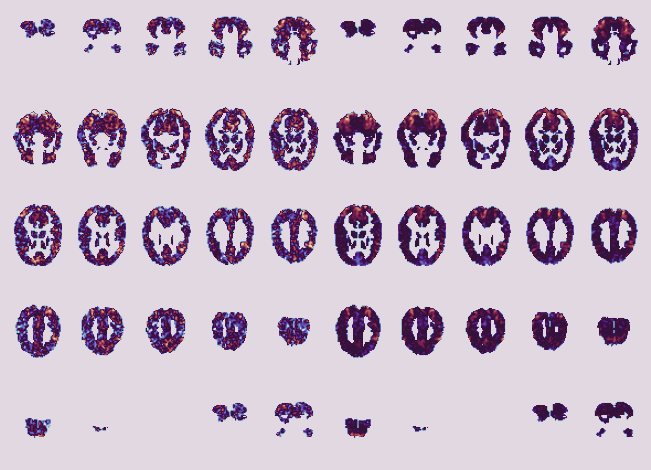

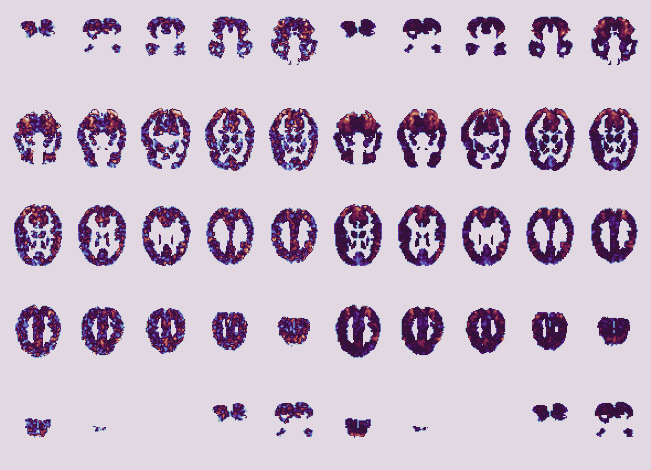

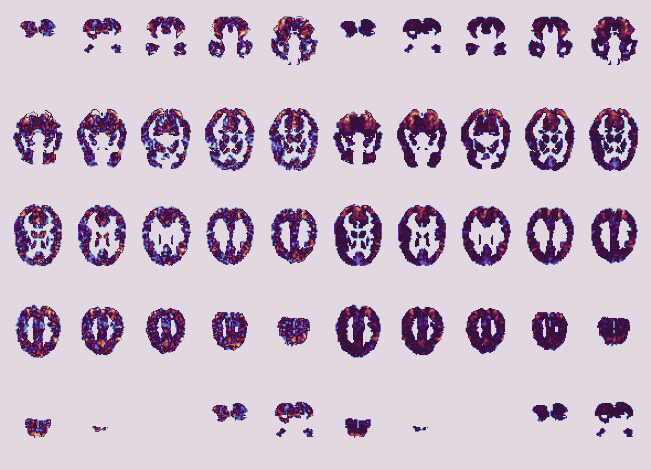

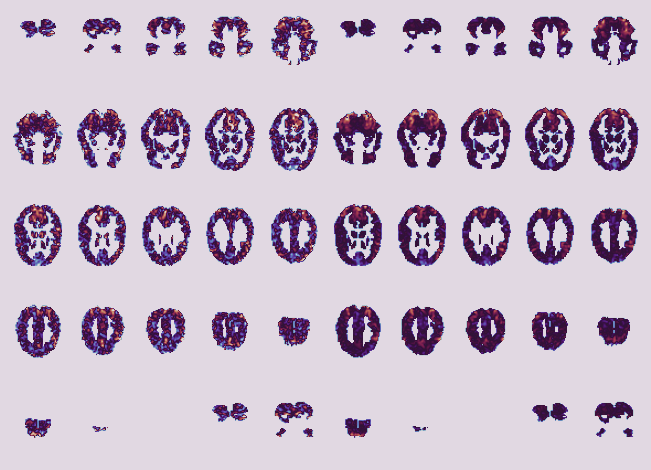

In [8]:
model = BasisSum()

loss = losses.CosineSimilarity()
opt = optimizers.Adam(0.01)

for i in range(501):
    if i % 100 == 0:
        pred = model(test_x).numpy()
        print(float(loss(test_y, pred)), end=" ")

    with tf.GradientTape() as tape:
        pred_y = model(train_x)
        batchloss = loss(train_y, pred_y)

        grad = tape.gradient(batchloss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))

        print(i, float(batchloss))

for t, p in zip(test_y, pred):
    double_plot(t, p)